# Курсовой проект. Real Estate Price Prediction

## Навигатор
* [1. Подключение необходимых библиотек и данных](#lib)
* [2. Загрузка данных в Data Frame](#load)
* [3. EDA](#eda)
    * [3.1. Основная информация о Data Frame](#eda_def)
    * [3.2. Исследование вещественных признаков](#eda_material)
    * [3.3. Исследование номинативных признаков](#eda_nom)
    * [3.4. Исследование целевой переменной](#eda_target)
    * [3.5. Матрица корреляций](#matrix_cor)
* [4. Обработка выбросов и пропусков](#out_nan)
    * [4.1. Вещественные признаки](#out_nan_def)
    * [4.1. Номинативные признаки](#out_nan_mat)
* [5. Классы подготовки данных](#data_prepare)
* [6. Дополнительные переиспользуемые функции](#dop_func)
* [7. Разбиение на train и test](#split)
* [8. Построение модели](#modeling)
* [9. Прогнозирование на тестовом датасете](#prediction)

## 1. Подключение необходимых библиотек и данных <a class='anchor' id='lib'>
По мере необходиомсти, в самом начале будем подключать все библиотеки и прописывать глобальные пути и переменные.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

dataset_path = './train.csv'
test_dataset_path = './test.csv'

## 2. Загрузка данных в Data Frame <a class='anchor' id='load'>

### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные

### Описание признаков данных
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [2]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(dataset_path, sep=',')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


## 3. EDA <a class='anchor' id='eda'>

### 3.1. Основная информация о Data Frame <a class='anchor' id='eda_def'>

In [3]:
# Посмотрим основную информацию по все признакам
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [4]:
# Уберем идентификаторы и районы из ввещественных признаков
df_train['Id'] = df_train['Id'].astype(str)
# df_train['DistrictId'] = df_train['DistrictId'].astype(str)

In [5]:
# Посмотрим основные статистики
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### 3.2. Исследование вещественных признаков <a class='anchor' id='eda_material'>

Количество уникальных значений признака DistrictId

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

Количество уникальных значений признака Rooms

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Количество уникальных значений признака Square

47.981561     1
56.484305     1
36.417766     1
37.253108     1
58.992068     1
             ..
76.729917     1
56.984833     1
104.745206    1
55.278957     1
38.666645     1
Name: Square, Length: 10000, dtype: int64

Количество уникальных значений признака LifeSquare

29.442751    1
23.141324    1
61.794489    1
31.274472    1
42.007038    1
            ..
61.334170    1
39.856885    1
19.131393    1
31.807667    1
21.157874    1
Name: LifeSquare, Length: 7887, dtype: int64

Количество уникальных значений признака KitchenSquare

1.0   

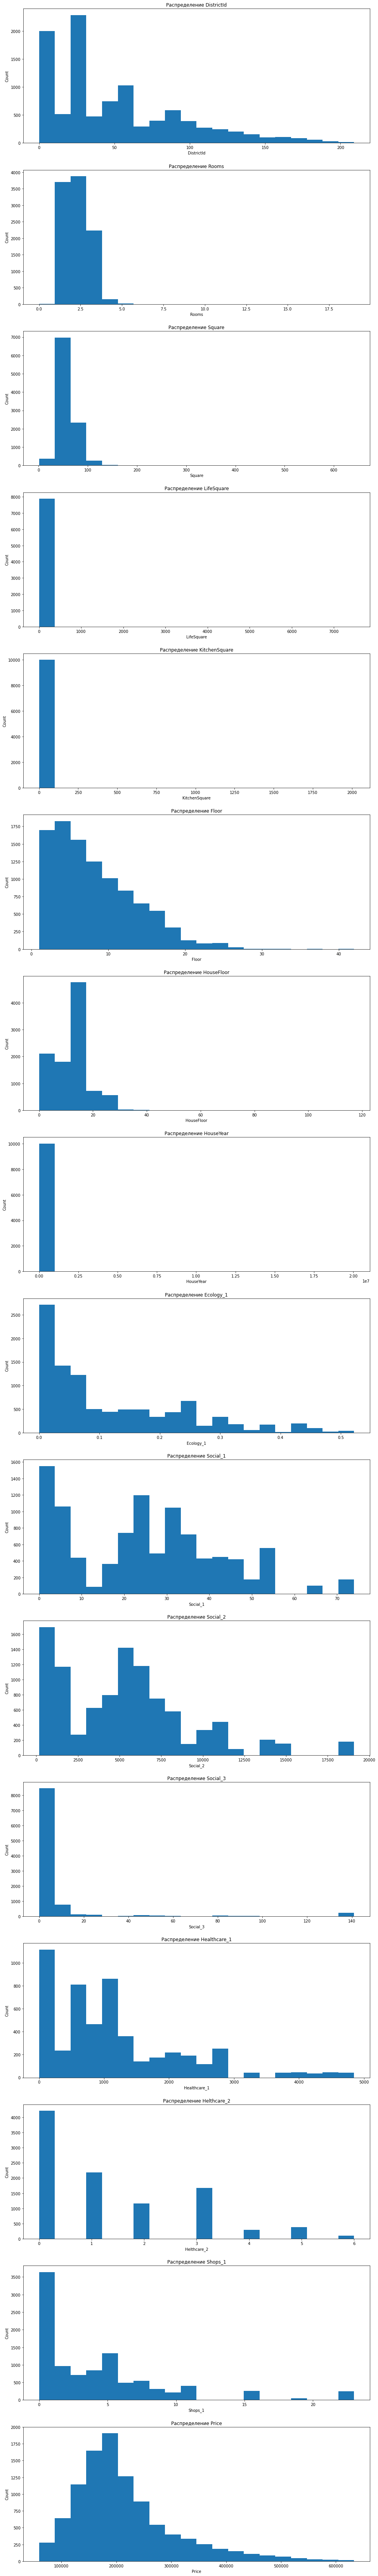

In [6]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])
fig, axs = plt.subplots(len(df_num_features.columns), 1, figsize=(16,121))

for j, i in enumerate(df_num_features):
    print('Количество уникальных значений признака ' + i + '\n')
    print(df_train[i].value_counts())
    axs[j].hist(df_train[i], bins=20)
    axs[j].set_title('Распределение ' + i)
    axs[j].set_xlabel(i)
    axs[j].set_ylabel('Count')
    print()

### Выводы по вещественным признакам

#### Rooms
Есть аномалия с квартирами, где количество комнат 0. Таких квартир 8 шт. Есть две квартиры по 10 и 19 комнат, что можно расценивать как выброс.

#### Square
Аномальия по 0 значению, а так же есть явно завышеныне площади. Требуется чистка данных.

#### LifeSquare
На графике видно, что есть большой выброс, который даже больше общей площади. При обработке данных максимально изучим данный признак для очистки.

#### KitchenSquare
Исходя из данных есть 697 объектов с площадью кухни 0 кв. м. - скорее всего это просто признак отсутствия кухни и соотвественно признак студии. 2460 объеков с площадью кухни 1 кв. метр - скорее всего это признака наличия кухни - надо заменить медианным значением.

#### HouseFloor
Есть 269 объекто в высотой здания в 0 кв. метров - такого быть не может. Т.к. минимальное значение этажа 1. Справа видим, что есть выбросы. 

#### HouseYear
Есть значения превышающие нормальные значения. Минимальные значения находятся в норме.

#### Social 1 
и далее сложно проанализировать на нормальность, так как нет никаких оснований для какой-то объективной трактовки этих данных.

#### Price
Целевая переменная. Вероятно в условных единицах, они же доллары США.

### 3.3. Исследование номинативных признаков <a class='anchor' id='eda_nom'>

In [7]:
df_obj_features = df_train.select_dtypes(include=['object'])

for i in df_obj_features:
    print('Количество уникальных значений признака ' + i + '\n')
    print(df_train[i].value_counts())
    print()

Количество уникальных значений признака Id

14038    1
4701     1
7719     1
11693    1
9327     1
        ..
6316     1
283      1
15042    1
6039     1
6306     1
Name: Id, Length: 10000, dtype: int64

Количество уникальных значений признака Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64

Количество уникальных значений признака Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64

Количество уникальных значений признака Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64



### Выводы по номинативным признакам

#### DistrictId
Явных аномальий нет. Объекты представлены в 205 районах.
Минимальное значение 0 может говоить о том, что индексация начинается с 0. Всего таких значений 48. В целом район можно назвать категориальным признаком, переведенный в числовое значение.

#### Ecology_2
Больше всего объектов относится к классу B

#### Ecology_3
Больше всего объектов относится к классу B

#### Shops_2
Больше всего объектов относится к классу B

### 3.4. Исследование целевой переменной <a class='anchor' id='eda_target'>
Построим график распределения целевой переменной "Price" - стоимости квартир

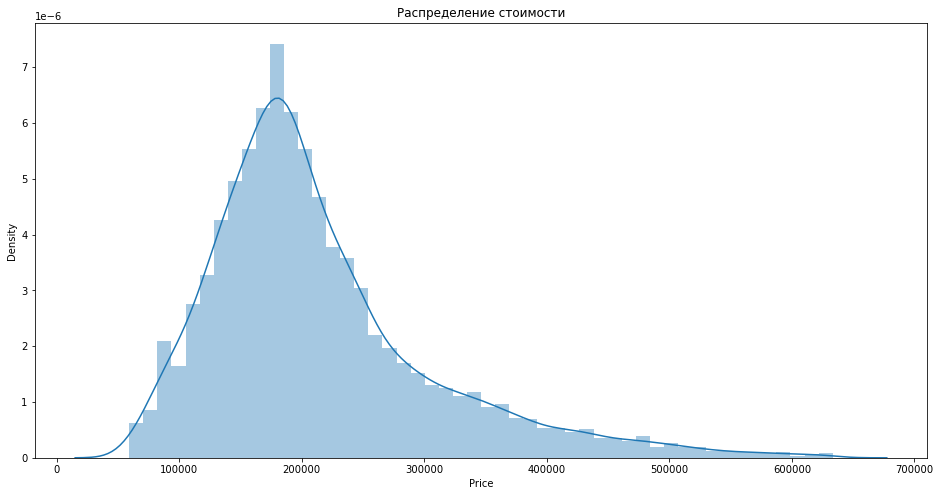

In [8]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'])

plt.title('Распределение стоимости')
plt.show()

### Вывод по целевой переменной
Плотность распределения целевой переменной нормальная. Большинство квартир встречаются в среднем ценовом диапазоне, по мере увеличения стоимости жилья формируется длинный хвост данных. 

### 3.5. Матрица корреляций <a class='anchor' id='matrix_cor'>

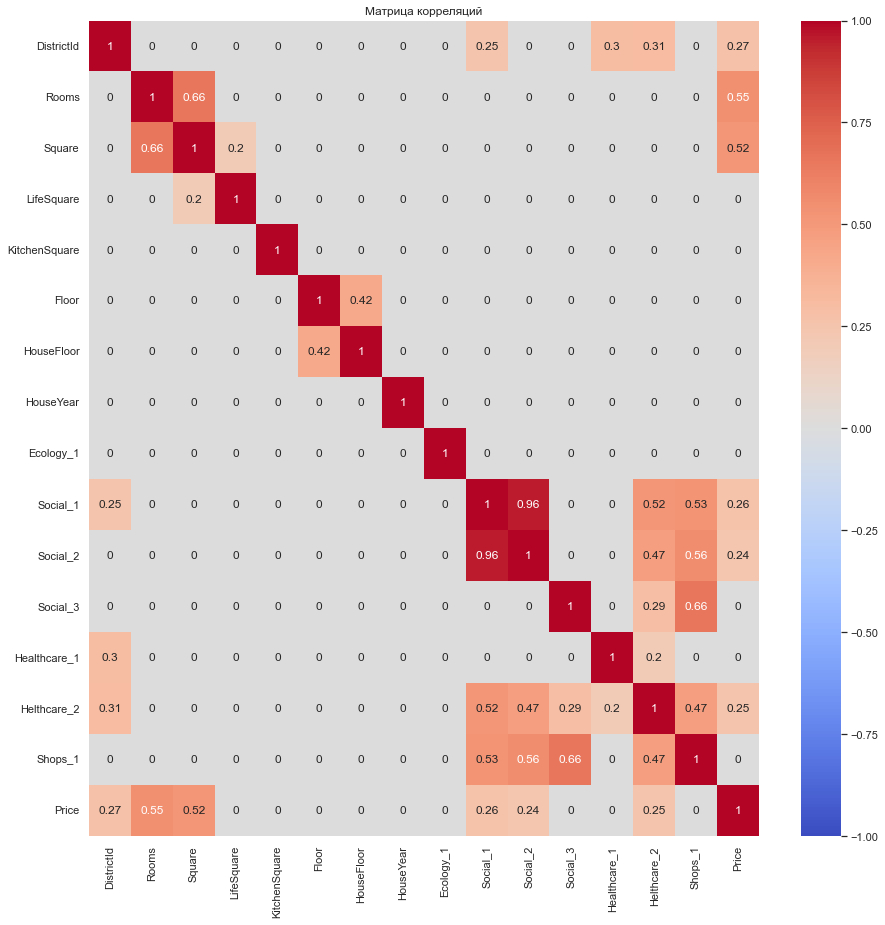

In [9]:
sns.set(rc={'figure.figsize':(15,15)})


corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

plt.title('Матрица корреляций')
plt.show()

### Вывод по корреляционной матрице
1. Наблюдается значительная положительная корреляция целевой переменной и количества комнат и площади. Так же выявилась слабая зависимость от района, социальных показателей 1 и 2, параметра медицины 2.
2. Есть явная положительная корреляция этажа от этажности дома.
3. Хорошо видна положительная корреляция всех социальных показателей и показателя здоровья 2 от наличия магазинов.
4. Есть слабая корреляция показателей здоровья и социального показателя 1 от района.
5. Социальные показатели 1 и 2 имеют крайне высокую корреляционную связь. Скорее всего для модели лучше оставить только один из этих показателей

## 4. Обработка выбросов и пропусков <a class='anchor' id='out_nan'>
### 4.1. Вещественные признаки <a class='anchor' id='out_nan_def'>

### Rooms

In [10]:
df_train.loc[(df_train['Rooms'] == 0)|(df_train['Rooms'] >= 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646


In [11]:
df_train.groupby(df_train['Rooms']).median()

,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Rooms,,,,,,,,,,,,,,,
0.0,27.0,65.487474,85.125471,0.0,4.5,1.5,1979.5,0.169389,9.0,1892.0,0.0,861.5,0.0,0.5,214937.068787
1.0,30.0,40.406590,21.663929,6.0,8.0,14.0,1977.0,0.075779,23.0,5148.0,1.0,830.0,1.0,3.0,154979.497993
2.0,35.0,55.841812,32.552134,6.0,7.0,12.0,1977.0,0.075779,25.0,5285.0,2.0,990.0,1.0,3.0,200320.754636
3.0,44.0,77.413643,46.960480,7.0,8.0,14.0,1977.0,0.072158,25.0,5569.0,2.0,830.0,1.0,4.0,268723.157677
4.0,58.5,98.668054,64.946548,9.0,6.0,10.0,1985.0,0.072158,29.5,6145.0,4.0,1046.0,1.0,5.0,377524.231990
5.0,57.5,116.084861,80.458910,9.0,5.5,6.5,1977.0,0.081478,24.0,4916.5,3.0,1863.5,1.0,5.0,455355.638212
6.0,99.0,59.414334,38.702244,6.0,7.0,9.0,1969.0,0.033494,66.0,10573.0,1.0,1322.0,3.0,8.0,229661.964416
10.0,33.0,59.964120,37.321877,10.0,12.5,12.0,1998.0,0.126165,49.5,12365.5,1.5,30.0,3.5,9.5,244797.297328
19.0,1.0,42.006046,21.779288,7.0,17.0,17.0,2014.0,0.007122,1.0,264.0,0.0,NaN,0.0,1.0,78364.616704


Заменим объекты с 0, 10 и 19 комнатами на количество комнат близкое по метражу. 1 комната до 50 кв.м., 2 комнаты до 65 кв. м, 3 комнаты до 90 кв. м.,  свыше 90 кв. м. 4 комнаты

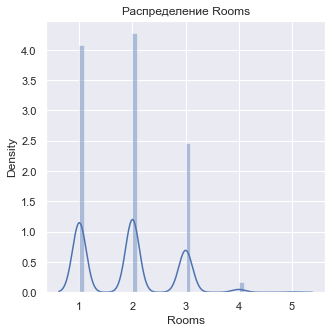

In [12]:
# Обработаем выбросы и нулевые значения комнат
df_train.loc[(df_train['Square'] <= 50)&((df_train['Rooms'] == 0)|(df_train['Rooms'] >= 6)), 'Rooms'] = 1
df_train.loc[(df_train['Square'] <= 65)&((df_train['Rooms'] == 0)|(df_train['Rooms'] >= 6)), 'Rooms'] = 2
df_train.loc[(df_train['Square'] <= 90)&((df_train['Rooms'] == 0)|(df_train['Rooms'] >= 6)), 'Rooms'] = 3
df_train.loc[((df_train['Rooms'] == 0)|(df_train['Rooms'] >= 6)), 'Rooms'] = 4

sns.set(rc={'figure.figsize':(5,5)})
# посмотрим распределение
sns.distplot(df_train['Rooms'])
plt.title('Распределение Rooms')
plt.show()

### Square, LifeSquare, KitchenSquare

In [13]:
# рассчитаем служебные медианы
median_s = df_train['Square'].median()
median_ks = df_train['KitchenSquare'].median()
median_ls = df_train['LifeSquare'].median()

In [14]:
df_train[df_train['Square']<=10].describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,3.000000,12.000000,12.000000,12.000000
mean,27.166667,1.416667,3.700918,18.654549,0.833333,10.500000,9.083333,1986.333333,0.109503,15.083333,3399.25000,1.583333,1234.333333,0.916667,3.166667,267628.420517
std,24.293034,0.792961,1.414591,27.945305,0.389249,9.681285,9.903703,16.897194,0.090977,16.913998,4008.83046,2.151462,1219.982104,1.505042,3.857303,152024.474252
min,1.000000,1.000000,1.136859,0.873147,0.000000,1.000000,0.000000,1977.000000,0.007122,1.000000,264.00000,0.000000,520.000000,0.000000,0.000000,97560.720383
25%,5.750000,1.000000,2.541575,4.054856,1.000000,3.000000,1.000000,1977.000000,0.016149,3.500000,803.50000,0.000000,530.000000,0.000000,0.750000,134847.436543
50%,27.000000,1.000000,4.385528,4.937913,1.000000,7.000000,2.500000,1977.000000,0.098565,9.000000,1892.00000,0.000000,540.000000,0.000000,1.000000,209575.753425
75%,35.000000,1.250000,4.681044,14.409538,1.000000,18.750000,17.500000,1986.000000,0.199686,17.750000,3877.75000,3.250000,1591.500000,1.500000,5.500000,418884.612154
max,88.000000,3.000000,5.497061,79.767964,1.000000,28.000000,25.000000,2016.000000,0.243205,53.000000,13670.00000,6.000000,2643.000000,4.000000,11.000000,483283.488083


In [15]:
df_train[df_train['Square']>=300].describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,47.000000,1.666667,551.732115,524.401471,7.000000,13.666667,13.666667,2004.000000,0.133409,24.333333,5311.666667,49.333333,593.666667,2.666667,11.000000,137239.118310
std,48.774994,0.577350,124.575061,160.883370,5.196152,8.504901,8.386497,23.430749,0.121731,2.081666,1287.870465,79.425017,517.068983,0.577350,10.440307,48729.411422
min,9.000000,1.000000,409.425181,410.639749,1.000000,4.000000,4.000000,1977.000000,0.000078,22.000000,3889.000000,1.000000,30.000000,2.000000,4.000000,90470.430830
25%,19.500000,1.500000,507.065577,467.520610,5.500000,10.500000,11.000000,1996.500000,0.080805,23.500000,4768.500000,3.500000,367.500000,2.500000,5.000000,112000.056196
50%,30.000000,2.000000,604.705972,524.401471,10.000000,17.000000,18.000000,2016.000000,0.161532,25.000000,5648.000000,6.000000,705.000000,3.000000,6.000000,133529.681562
75%,66.000000,2.000000,622.885582,581.282332,10.000000,18.500000,18.500000,2017.500000,0.200074,25.500000,6023.000000,73.500000,875.500000,3.000000,14.500000,160623.462050
max,102.000000,2.000000,641.065193,638.163193,10.000000,20.000000,19.000000,2019.000000,0.238617,26.000000,6398.000000,141.000000,1046.000000,3.000000,23.000000,187717.242538


Квартир с метражом менее 10 метров не существует, так же как и маловероятно существование квартир с метражом более 300 метров. Поменяем метраж на медианное значение для таких объектов.

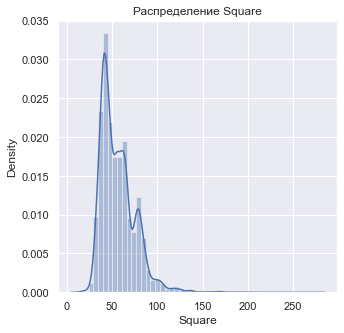

In [16]:
# Уберем объекты площадью меньше 10 и больше 300. Урежем хвосты и околонулевые значения
df_train.loc[df_train['Square'] > 300, 'Square'] = df_train['Square'].median()
df_train.loc[df_train['Square'] < 10, 'Square'] = df_train['Square'].median()

# посмотрим распределение
sns.distplot(df_train['Square'])
plt.title('Распределение Square')
plt.show()

In [17]:
# Ранее были обнаружены 697 объектов с площадью кухни 0 кв. метров. 
# Будем считать эти объекты с кухнями совмещенными с жилой комнатой. Введем новое поле с признаком студии.
df_train['Studio_type'] = np.where(df_train['KitchenSquare'] == 0, 1,0)

In [18]:
# Ранее были обнаружены 2460 объеектов с площадью кухни 1 кв. метр.
# Будем считать это принзнаком наличия кухни, заменим это значение медианой.
df_train.loc[(df_train['KitchenSquare'] == 1), 'KitchenSquare'] = median_ks

In [19]:
# Заменим площади кухонь более 100 кв. метров на медианное значение.

df_train.loc[df_train['KitchenSquare'] > 100, 'KitchenSquare'] = median_ks

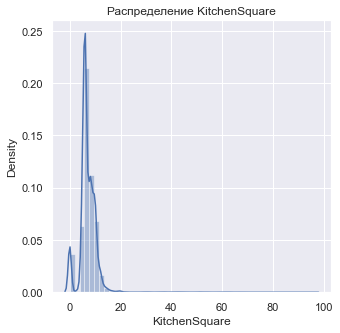

In [20]:
sns.distplot(df_train['KitchenSquare'])
plt.title('Распределение KitchenSquare')
plt.show()

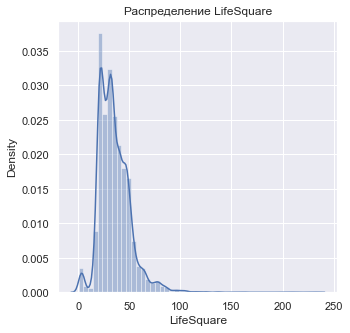

In [21]:
#Исправим пропуски LifeSquare как произведение общей площади на коэффциент жилой площади от общей, 
# а так же объекты где жилая площадь больше общей
k_median_ls = median_ls / median_s
df_train.loc[(df_train['LifeSquare'] > df_train['Square']) | 
             (df_train['LifeSquare'].isna()), 'LifeSquare'] = k_median_ls * df_train['Square']

sns.distplot(df_train['LifeSquare'])
plt.title('Распределение LifeSquare')
plt.show()

### HouseYear

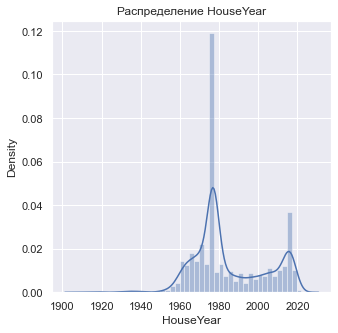

In [22]:
# изменим год постройки на текущий год, если он больше, чем текущая дата
now = datetime.datetime.now()
df_train.loc[(df_train['HouseYear'] > now.year), 'HouseYear'] = now.year

sns.distplot(df_train['HouseYear'])
plt.title('Распределение HouseYear')
plt.show()

### Floor, HouseFloor
Проверим, чтобы этаж не был больше этажности дома и оба параметра не были равны 0

In [23]:
df_train['Floor'].mode()[0]

4

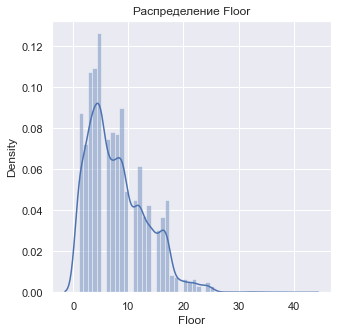

In [24]:
# обработаем нулевые этажи
df_train.loc[(df_train['Floor'] == 0), 'Floor'] = df_train['Floor'].mode()[0]
df_train.loc[(df_train['HouseFloor'] == 0), 'HouseFloor'] = df_train['HouseFloor'].mode()[0]

# обработаем ситуацию когда этаж больше этажности
df_train.loc[(df_train['Floor'] > df_train['HouseFloor']), 'Floor'] = df_train['HouseFloor']

sns.distplot(df_train['Floor'])
plt.title('Распределение Floor')
plt.show()

### Healthcare_1 
Удалим столбец 

In [25]:
df_train.drop('Healthcare_1', axis=1, inplace=True)

### Social_2 
Удалим столбец 

In [26]:
df_train.drop('Social_2', axis=1, inplace=True)

### Результат обработки вещественных признаков
Посмотрим как изменились распределения после очистки

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
Studio_type      0
dtype: int64
















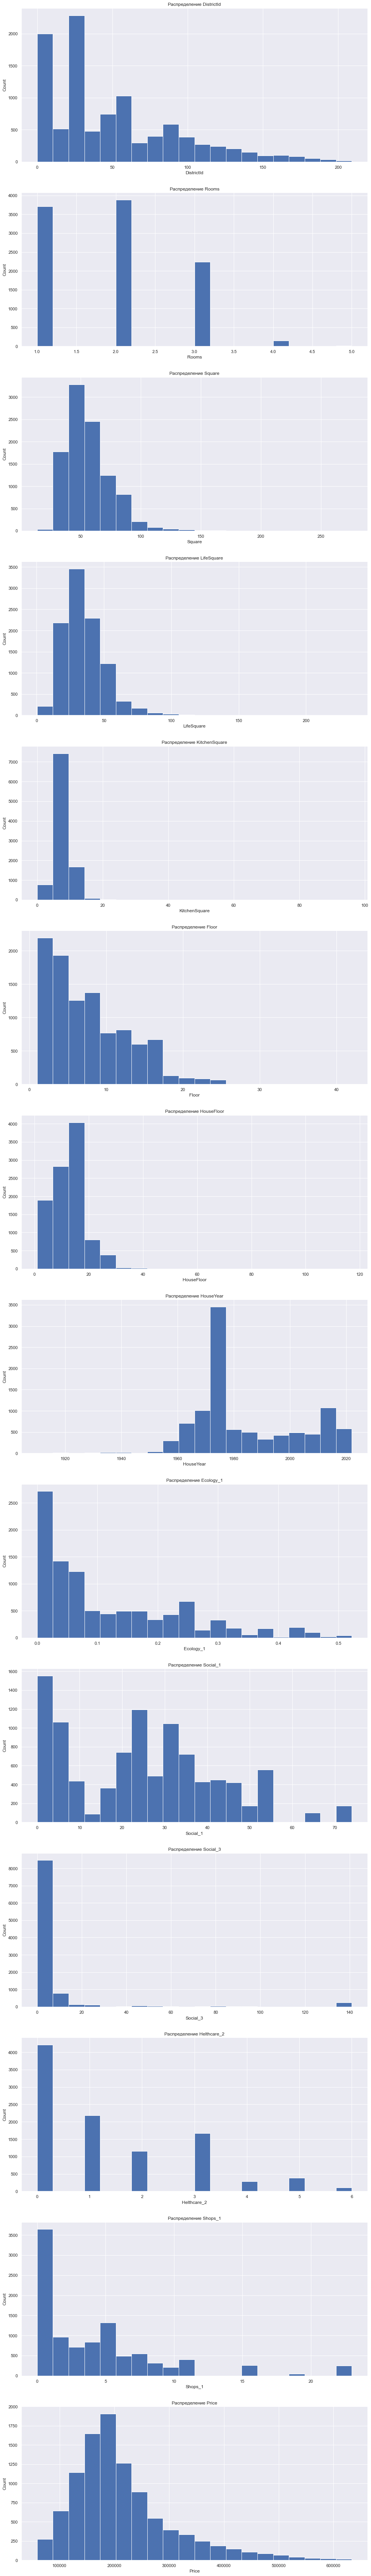

In [27]:
print(df_train.isna().sum())

df_num_features = df_train.select_dtypes(include=['float64', 'int64'])
fig, axs = plt.subplots(len(df_num_features.columns), 1, figsize=(16,121))


for j, i in enumerate(df_num_features):
    axs[j].hist(df_train[i], bins=20)
    axs[j].set_title('Распределение ' + i)
    axs[j].set_xlabel(i)
    axs[j].set_ylabel('Count')
    print()

### 4.2. Номинативные признаки <a class='anchor' id='out_nan_mat'>

In [28]:
# Заменим буквенные значения на числовые
litera = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].replace(litera)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(litera)
df_train['Shops_2'] = df_train['Shops_2'].replace(litera)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Studio_type
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,5,0,11,1,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,1,1,16,1,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,0,1,3,1,220925.908524,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,3,0,5,1,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,1,2,4,1,150226.531644,0


## 5. Классы подготовки данных <a class='anchor' id='data_prepare'>

In [29]:
class dataPrepare:

    def __init__(self):
        self.medians = None  # сохраним все медианы
        self.k_median_ks = None  # переменная для коэфициента медиан 
        
    def fit(self, X):
        self.medians = X.median()  # Расчет медиан
    
    def transform(self, X):
        # Обработаем выбросы и нулевые значения Rooms
        X.loc[(X['Square'] <= 50)&((X['Rooms'] == 0)|(X['Rooms'] >= 6)), 'Rooms'] = 1
        X.loc[(X['Square'] <= 65)&((X['Rooms'] == 0)|(X['Rooms'] >= 6)), 'Rooms'] = 2
        X.loc[(X['Square'] <= 90)&((X['Rooms'] == 0)|(X['Rooms'] >= 6)), 'Rooms'] = 3
        X.loc[((X['Rooms'] == 0)|(X['Rooms'] >= 6)), 'Rooms'] = 4

        # Уберем объекты площадью меньше 4 и больше 150. Урежем хвосты и околонулевые значения
        X.loc[X['Square'] > 300, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < 10, 'Square'] = self.medians['Square']
        
        # Добавим признак студии
        X['Studio_type'] = np.where(X['KitchenSquare'] == 0, 1,0)
        
        # Для кухонь с площадью 1 кв. метр заменим на медиану
        X.loc[(X['KitchenSquare'] == 1), 'KitchenSquare'] = self.medians['KitchenSquare']

        # Уберем хвост из площадей больше 100
        X.loc[X['KitchenSquare'] > 100, 'KitchenSquare'] = self.medians['KitchenSquare']

        # Исправим пропуски LifeSquare как произведение общей площади на коэффциент жилой площади от общей
        k_median_ls = self.medians['LifeSquare'] / self.medians['Square']
        X.loc[(X['LifeSquare'] > X['Square']) | 
             (X['LifeSquare'].isna()), 'LifeSquare'] = k_median_ls * X['Square']
        
        # изменим год постройки на текузий год, если он больше, чем текущая дата
        now = datetime.datetime.now()
        X.loc[(X['HouseYear'] > now.year), 'HouseYear'] = now.year

        # обработаем нулевые этажи
        X.loc[(X['Floor'] == 0), 'Floor'] = X['Floor'].mode()[0]
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = X['HouseFloor'].mode()[0]
        

        # обработаем ситуацию когда этаж больше этажности
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['HouseFloor']

        # Удалим признак Social_2
        if 'Social_2' in X.columns:
            X.drop('Social_2', axis=1, inplace=True)

        # Удалим признак Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
            # Удалим признак id
        if 'Id' in X.columns:
            X.drop('Id', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
    
        
        return X


class dataDummies():
    
    def __init__(self):
        self.binary_to_numbers = None
        
    def fit(self):
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    def transform(self, X):
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        return X

## Дополнительные переиспользуемые функции <a class='anchor' id='dop_func'>

In [30]:
def r2_metrics(y_tr, y_vl, y_tr_prd, y_vl_prd):
    # Посчитаем коэффициент детерминации R2
    print("R2 TRAIN:\t" + str(r2_score(y_tr, y_tr_prd)))
    print("R2 TEST:\t" + str(r2_score(y_vl, y_vl_prd)))

    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(y_tr_prd, y_tr)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Тренировочные значения')
    plt.title('Тренировочные предсказания')
    
    plt.subplot(122)
    sns.scatterplot(y_vl_prd, y_vl)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Валидационные значения')
    plt.title('Валидационные предсказания')
    plt.show()

## 7. Разбиение на train и test <a class='anchor' id='split'>

In [31]:
# Импортируем данные
df_train = pd.read_csv(dataset_path)
X_test = pd.read_csv(test_dataset_path)

# Создадим объекты классов и проинициализируем переменные
d_prepare = dataPrepare()
d_dummies = dataDummies()
d_prepare.fit(X_test)
d_dummies.fit()

# Подготовим данные
df_train = d_prepare.transform(df_train)
df_train = d_dummies.transform(df_train)
X_test = d_prepare.transform(X_test)
X_test = d_dummies.transform(X_test)

# Отделим целевую переменную
X = df_train.drop('Price', axis=1)
y = df_train['Price']

# Создадим тренировочные и валидацонные наборы
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# Посмотрим на размерности и пропуски в данных. После обработки их не должно быть
print(X_train.shape, X_valid.shape, X_test.shape)
print(X_train.isna().sum().sum(), 
      X_valid.isna().sum().sum(),
      X_test.isna().sum().sum())

(6700, 17) (3300, 17) (5000, 17)
0 0 0


## 8. Построение модели <a class='anchor' id='modeling'>

### Линейная регрессия

lr = LinearRegression()
lr.fit(X_train, y_train)


y_train_pred_lr = lr.predict(X_train)
y_valid_pred_lr = lr.predict(X_valid)

r2_metrics(y_train, y_valid, y_train_pred_lr, y_valid_pred_lr)

### Вывод
Модель не дает необходимого результата качества предсказания

R2 TRAIN:	0.5386333040823755

R2 TEST:	0.5071280295872438

### Случайный лес
На основве сетки удалось улучшить модель с 0.724 до 0.730. При этом для тренировочных данных R2 упала с 0.94 до 0.88, тем самым удалось снизить переобучение

%%time
parameters = [{'n_estimators': [200, 250, 300], 
                'max_features': np.arange(3, 8),
               'max_depth': np.arange(9, 13)}]

from sklearn.model_selection import GridSearchCV

gcv = GridSearchCV(estimator = RandomForestRegressor(random_state=21),
                    param_grid = parameters,
                   scoring = 'r2',
                     cv=KFold(n_splits=4,   # k (кол-во разбиений/итераций) в кросс-валидации
                              random_state=21, 
                              shuffle=True),
                    n_jobs=-1,
                   )

gcv.fit(X_train, y_train)

gcv.best_params_

rfr = RandomForestRegressor(n_estimators=300, max_features=7, max_depth=12, random_state=21, criterion='mse')
rfr.fit(X_train, y_train)
y_train_pred_rf = rfr.predict(X_train)
y_valid_pred_rf = rfr.predict(X_valid)

r2_metrics(y_train, y_valid, y_train_pred_rf, y_valid_pred_rf)

imp = pd.DataFrame({'feature': X_train.columns,'importance': rfr.feature_importances_})
imp = imp.sort_values('importance', ascending=False).set_index('feature')

print(imp)

imp.plot.bar()

### Вывод
Модель RandomForestRegressor на тренировочных данных показала себя хорошо, но на валидационных значительно хуже. Однако это гораздо лучше, чем линейная регрессия.

- R2 TRAIN:	0.9034500864021563
- R2 TEST:	0.7303272762188592

Наиболее важными признаками оказались:
- Square           0.287364
- Rooms            0.120262
- Social_1         0.114331
- LifeSquare       0.097796

### Gradient Boosting Regressor

In [32]:
scaler = RobustScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=colnames)


gbr = GradientBoostingRegressor(criterion='mse',
                                        max_depth=4,
                                        random_state=21,  
                                        n_estimators=350,
                                        min_samples_leaf=10
                               )

#gbr.fit(X_train_scaled, y_train)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=10,
                          n_estimators=350, random_state=21)

In [33]:
#%%time
#params = {'n_estimators':[350, 1000], 
#          'max_depth':[3, 4],
#          'min_samples_leaf':[9, 10, 11]}

#gs = GridSearchCV(gbr, params, 
#                  scoring='r2', # метрика 
#                  cv=KFold(n_splits=4,   # k (кол-во разбиений/итераций) в кросс-валидации
#                           random_state=21, 
#                           shuffle=True),
#                  n_jobs=-1
#                  )
#gs.fit(X_train, y_train)

In [34]:
#gs.best_params_

R2 TRAIN:	0.875177017439199
R2 TEST:	0.7397598812184891


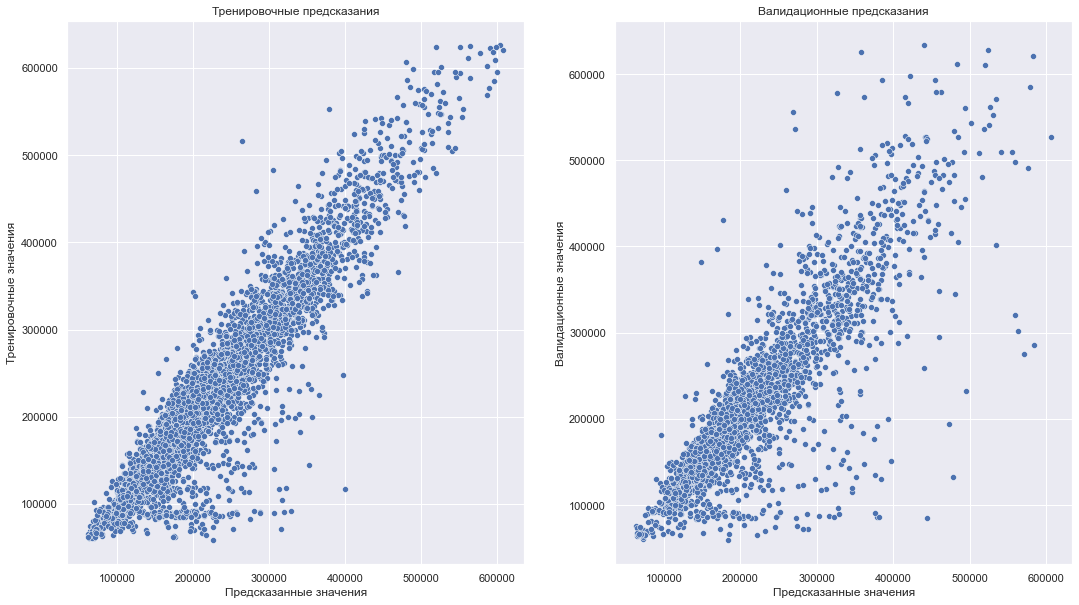

In [35]:
#y_train_preds_gbr = gbr.predict(X_train_scaled)
#y_valid_preds_gbr = gbr.predict(X_valid_scaled)

#r2_metrics(y_train, y_valid, y_train_preds_gbr, y_valid_preds_gbr)

y_train_preds_gbr = gbr.predict(X_train)
y_valid_preds_gbr = gbr.predict(X_valid)

r2_metrics(y_train, y_valid, y_train_preds_gbr, y_valid_preds_gbr)

               importance
feature                  
Square           0.444911
Social_1         0.163797
Social_3         0.076352
DistrictId       0.068818
Rooms            0.056884
Ecology_1        0.055549
HouseYear        0.031267
KitchenSquare    0.021418
Shops_1          0.021193
HouseFloor       0.019810
LifeSquare       0.019685
Floor            0.011279
Helthcare_2      0.007889
Ecology_3        0.000677
Shops_2          0.000399
Ecology_2        0.000039
Studio_type      0.000035


<AxesSubplot:xlabel='feature'>

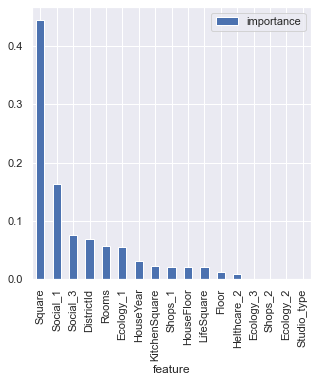

In [36]:
imp = pd.DataFrame({'feature': X_train_scaled.columns,'importance': gbr.feature_importances_})
imp = imp.sort_values('importance', ascending=False).set_index('feature')

print(imp)

imp.plot.bar()

### Вывод по Gradient Boosting Regressor
На основе наблюдений хороших показателей получилось достигнуть с параметрами
- max_depth=4,
- n_estimators=350,
- min_samples_leaf=10,

значения R2 вышли
- R2 TRAIN:	0.875177017439199
- R2 TEST:	0.7397598812184891

При этом наблюдается некоторое переобучение модели, вероятно, на признаке Square, т.к. его важность имеет значение в районе 0,4
              
- Square           0.444914
- Social_1         0.163818
- Social_3         0.076456
- DistrictId       0.068807
- Rooms            0.056884
- Ecology_1        0.055550


## 9. Прогнозирование на тестовом датасете <a class='anchor' id='prediction'>

In [37]:
# Снова для чистоты импортируем данные
X_train = pd.read_csv(dataset_path)
X_test = pd.read_csv(test_dataset_path)

#Создадим заготовку итогового файла
preds_final = pd.DataFrame()
preds_final['Id'] = X_test['Id'].copy()

# Создадим объекты классов и проинициализируем переменные
d_prepare = dataPrepare()
d_dummies = dataDummies()
d_prepare.fit(X_test)
d_dummies.fit()

# Подготовим данные
X_train = d_prepare.transform(X_train)
X_train = d_dummies.transform(X_train)
X_test = d_prepare.transform(X_test)
X_test = d_dummies.transform(X_test)

# Отделим целевую переменную
X = X_train.drop('Price', axis=1)
y = X_train['Price']

# Посмотрим на размерности и пропуски в данных. После обработки их не должно быть
print(X.shape, X_test.shape)
print(X.isna().sum().sum(), 
      X_test.isna().sum().sum())

(10000, 17) (5000, 17)
0 0


In [38]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=4,
                                        random_state=21,  
                                        n_estimators=350,
                                        min_samples_leaf=10
                               )

final_model.fit(X, y)

y_train_preds_gbr = final_model.predict(X)
y_test_preds_gbr = final_model.predict(X_test)

In [39]:
preds_final['Price']=y_test_preds_gbr

In [40]:
preds_final

,Id,Price
0,725,161460.903379
1,15856,211065.049629
2,5480,214521.255176
3,15664,380957.137446
4,14275,146682.379669
...,...,...
4995,8180,234128.801921
4996,4695,135702.734339
4997,5783,342186.656502
4998,4780,186561.258538


In [41]:
preds_final.to_csv('./AAbramov_predictions.csv', index=False, encoding='utf-8', sep=',')